In [13]:
import json
import os
import numpy as np
import pandas as pd
import string
from tqdm import tqdm

In [2]:
documents_path = '../dis-project-1-document-retrieval/corpus.json/corpus.json'

In [3]:
with open(documents_path) as f:
    documents = json.load(f)

In [15]:
train_queries_path = '../dis-project-1-document-retrieval/train.csv'

In [16]:
# Load the training queries
train_queries = pd.read_csv(train_queries_path)

In [ ]:
count = 0
for _, query in train_queries.iterrows():
    query_id = query['query_id']
    query_text = query['query']
    relevant_docs = query['positive_docs']
    language = query['lang']
    if count == 1:
        print(query_id, query_text, relevant_docs, language)
        break
    count += 1


In [ ]:
documents[0]

In [17]:
def get_doc_by_id(doc_id):
    return next(doc for doc in documents if doc['docid'] == doc_id)

In [27]:
# count the queries which have relevant doucments whose language is not the query language
count = 0
for _, query in train_queries.iterrows():
    query_id = query['query_id']
    query_text = query['query']
    relevant_docs = query['positive_docs']
    language = query['lang']
    for doc_id in relevant_docs.split():
        doc_language = get_doc_by_id(doc_id)['lang']
        if language != doc_language:
            count += 1
            print(f'Query {query_id} has relevant document {doc_id} with language {doc_language} which is different from the query language {query_language}')

In [28]:
print(f'Total queries with relevant documents with different language: {count}')

Total queries with relevant documents with different language: 0


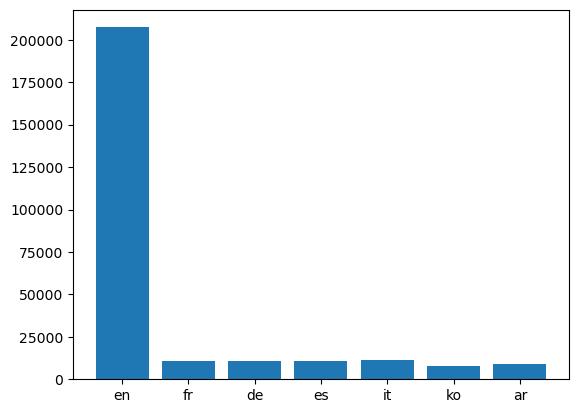

In [30]:
# look at the distibution of the langauges of the documents
from collections import Counter
doc_languages = [doc['lang'] for doc in documents]
doc_languages_counter = Counter(doc_languages)
# plot the distribution of the languages
import matplotlib.pyplot as plt
plt.bar(doc_languages_counter.keys(), doc_languages_counter.values())
plt.show()


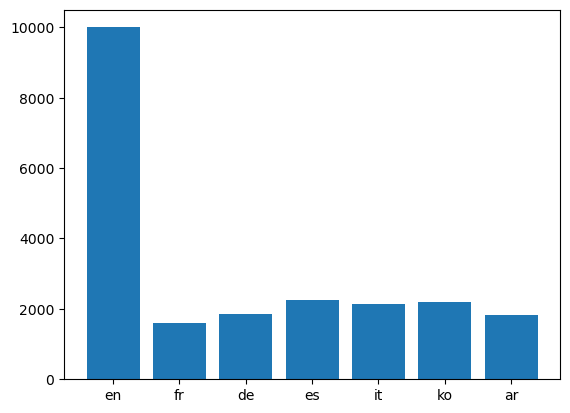

In [32]:
# look at the distibution of the langauges of the train queries
query_languages = train_queries['lang']
query_languages_counter = Counter(query_languages)
# plot the distribution of the languages
plt.bar(query_languages_counter.keys(), query_languages_counter.values())
plt.show()

In [35]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [36]:
query_text = 'What is the capital of France?'
tokenized_text = tokenizer.tokenize(query_text)
print(tokenized_text)

['what', 'is', 'the', 'capital', 'of', 'france', '?']


In [37]:
input_ids = tokenizer.encode(query_text, add_special_tokens=True)
print(input_ids)

[101, 2054, 2003, 1996, 3007, 1997, 2605, 1029, 102]


In [ ]:
# print all the

## TF-IDF

### Preprocessing

In [7]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

In [18]:
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional, for additional wordnet languages

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/robinfaro/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/robinfaro/nltk_data...


True

In [18]:
def get_langauge(lang_id):
    """
    Returns the language name given the language id in order to pass it to the stopwords function
    """
    cases = {
        'en' : 'english',
        'de' : 'german',
        'fr' : 'french',
        'es' : 'spanish',
        'it' : 'italian',
        'ar' : 'arabic',
        'ko' : 'korean'
    }
    return cases.get(lang_id, 'unknown') 

In [19]:
def preprocess_text(text, language_id):
    """
    Preprocess the text by removing stopwords, stemming and lemmatizing the text
    """
    # remove punctuation
    text = "".join([ch for ch in text if ch not in string.punctuation])
    # remove stopwords
    stop_words = set(stopwords.words(get_langauge(language_id)))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    # stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

### Function definition

In [20]:
def compute_tf(term, doc):
    """
    Compute the term frequency of a term in a document

    :param term: the term to compute its frequency
    :param doc: the document to compute the frequency of the term in

    :return: the term frequency of the term in the document
    """
    doc = doc['preprocessed_text']
    f_t = doc.count(term)
    max_f = max([doc.count(t) for t in set(doc)])
    return f_t / max_f

# def compute_idf(vocabularies, documents, languages):
    """
    Compute the inverse document frequency of a term in a list of documents
    :param term: the term to compute its inverse document frequency
    :param documents: the list of documents (SAME LANGUAGE of term)to compute the inverse document frequency of the term in
    """
    idfs = {}
    num_docs = {}
    for language in languages:
        idfs[language] = {}
        num_docs[language] = 0

    #     count = 0
    #     for term in vocabularies[language]:
    #         n = 0
    #         for doc in documents:
    #             if doc['lang'] == language:
    #                 if term in doc['preprocessed_text']:
    #                     n += 1
    #                 count += 1
    #         idfs[language][term] = np.log(count / n)
    
    
    for doc in documents:
        lang = doc['lang']
        num_docs[lang] += 1
        for term in set(doc['preprocessed_text']):
            if term not in idfs:
                idfs[lang][term] = 1
            else:
                idfs[lang][term] += 1
    
    for lang in idfs:
        for term in idfs[lang]:
            idfs[lang][term] = np.log(num_docs[lang] / idfs[lang][term])

    return idfs

# def pivoted_unique_query_norm_tf_idf(term, doc, documents, idfs, s=0.2):
    """
    Compute the term frequency - inverse document frequency of a term in a document
    """
    # calculate the number of unique terms in the document
    pivot = 0
    language = doc['lang']
    for document in documents:
        unique_terms = set(document['preprocessed_text'])
        pivot += len(unique_terms)
    pivot /= len(documents) # num
    u = len(set(doc['preprocessed_text']))
    tf = compute_tf(term, doc)
    idf = idf(term, documents)

    return tf * idf * ((1-s)* pivot + s * u)

In [34]:
def compute_pivot_idf(documents, languages):
    """
    Compute the pivoted unique query norm term frequency - inverse document frequency of a term in a document
    """
    idfs = {}
    num_docs = {}
    pivots = {}
    for language in languages:
        idfs[language] = {}
        num_docs[language] = 0
        pivots[language] = 0

    for doc in tqdm(documents):
        lang = doc['lang']
        num_docs[lang] += 1
        unique_terms = set(doc['preprocessed_text'])
        pivots[lang] += len(unique_terms)
        for term in unique_terms:
            if term not in idfs[lang]:
                idfs[lang][term] = 1
            else:
                idfs[lang][term] += 1

    for lang in idfs:
        for term in idfs[lang]:
            idfs[lang][term] = np.log(num_docs[lang] / idfs[lang][term])
        if num_docs[lang] != 0:
            pivots[lang] /= num_docs[lang]
        else:
            pivots[lang] = 0

    return idfs, pivots

def pivoted_unique_vector_norm_tf_idf(document, vocabularies, idfs, pivots, s=0.2):
    """
    Compute the pivoted unique vector norm term frequency - inverse document frequency of a term in a document
    """
    language = document['lang']
    unique_terms = set(document['preprocessed_text'])
    u = len(unique_terms)
    pivot = pivots[language]
    vocabulary = vocabularies[language]
    vector = [0]*len(vocabulary)
    # for i, term in tqdm(enumerate(vocabulary)):
    #     tf = compute_tf(term, document)
    #     idf = idfs[language][term]
    #     vector[i] = tf * idf * ((1-s)* pivot + s * u)
    for term in tqdm(unique_terms):
        if term in vocabulary:
            i = vocabulary.index(term)
            tf = compute_tf(term, document)
            idf = idfs[language][term]
            vector[i] = tf * idf * ((1-s)* pivot + s * u)
        else:
            print(f'Term {term} not in vocabulary')

    return vector
    

In [11]:
def compute_precison_at_k(retrieved_docs, relevant_docs, k):
    """
    Compute the precision at k
    """
    count = set(retrieved_docs[:k]).intersection(set(relevant_docs))
    return len(count) / k

def compute_recall_at_k(retrieved_docs, relevant_docs, k):
    """
    Compute the recall at k
    """
    count = set(retrieved_docs[:k]).intersection(set(relevant_docs))
    return len(count) / len(relevant_docs)

def compute_f1_at_k(retrieved_docs, relevant_docs, k):
    """
    Compute the f1 score at k
    """
    precision = compute_precison_at_k(retrieved_docs, relevant_docs, k)
    recall = compute_recall_at_k(retrieved_docs, relevant_docs, k)
    return 2 * precision * recall / (precision + recall)

## Experiments

In [39]:
def create_vocabulary_language(documents, languages):
    """
    Create the vocabularies for all the languages in the documents
    """
    vocabularies = {}
    for language in languages:
        vocabularies[language] = set()
    for doc in tqdm(documents):
        language = doc['lang']
        text = doc['text']
        preprocessed_text = preprocess_text(text, language)
        doc['preprocessed_text'] = preprocessed_text
        vocabularies[language].update(set(preprocessed_text))
    for language in languages:
        vocabularies[language] = list(vocabularies[language])
    return vocabularies

In [40]:
languages = ['en', 'de', 'fr', 'es', 'it', 'ar', 'ko']
truncated_documents = documents[:1000]

vocabularies = create_vocabulary_language(truncated_documents, languages)

100%|██████████| 1000/1000 [00:33<00:00, 29.49it/s]


In [ ]:
# save the vocabularies for each language in a json file
for language in languages:
    with open(f'vocabulary_{language}.json', 'w') as f:
        json.dump(list(vocabularies[language]), f)


In [28]:
# compute the idf for each language
idfs, pivots = compute_pivot_idf(truncated_documents, languages)


100%|██████████| 1000/1000 [00:00<00:00, 3330.46it/s]


In [30]:
len(idfs['en']), len(vocabularies['en'])

(195370, 195370)

In [41]:
type(vocabularies['en'])

list

In [43]:
vector_doc_0 = pivoted_unique_vector_norm_tf_idf(truncated_documents[0], vocabularies, idfs, pivots)

100%|██████████| 1027/1027 [00:21<00:00, 48.20it/s]


In [44]:
# count the number of non-zero elements in the vector
count = 0
for v in vector_doc_0:
    if v != 0:
        count += 1
print(count)

1027


In [45]:
documents_vectors = [pivoted_unique_vector_norm_tf_idf(doc, vocabularies, idfs, pivots) for doc in tqdm(truncated_documents)]

  3%|▎         | 28/1000 [19:17<11:09:35, 41.33s/it]


KeyboardInterrupt: 

In [47]:
# dump the truncated documents in a json file
with open('/Users/giudittadelsarto/Desktop/truncated_documents.json', 'w') as f:
    json.dump(truncated_documents, f)


In [ ]:
# prova